LSTM model to predict filtered shear stress

In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam, SGD
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Dropout, LeakyReLU
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from keras.utils import plot_model
import time
import tensorflow as tf
import h5py

In [2]:
## Function to create data history
# n_steps = 300 = 3s history
# Features (history): n-300, n-299, ... , n-2, n-1 
# Traget variable: n

def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]  #last column is the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)



In [3]:
# Load the data

data = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')
m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2), 'SS':data['SS'].ravel()})
a_t = pd.DataFrame({'Time':data['LocalAcTime'].ravel().round(2), 'V_filt':data['V_filt'].ravel(), 'Vel_pc':data['Vel_pc'].ravel()})  
df1 = a_t.merge(m_t, on='Time')

data2 = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_run1_pp_wAmp.mat')
df2 = pd.DataFrame({'maxFreqI_filt':data2['maxFreqI_filt'][3786:136185].ravel(), 'freqQAmpI_filt':data2['freqQAmpI_filt'][3786:136185].ravel(), 
                    'freqQAmpI_filt_pc':data2['freqQAmpI_filt_pc'].ravel()})

df = pd.concat([df1, df2], axis=1)

df = df[['freqQAmpI_filt', 'freqQAmpI_filt_pc', 'V_filt', 'Vel_pc', 'maxFreqI_filt', 'SS']]
print("Input data:\n", df)


Input data:
         freqQAmpI_filt  freqQAmpI_filt_pc  ...  maxFreqI_filt        SS
0         31453.223522                0.0  ...  457640.731368  5.656166
1         31438.277060                0.0  ...  457680.400524  5.657157
2         31421.341616                0.0  ...  457727.638932  5.658317
3         31409.798761                0.0  ...  457770.778724  5.659499
4         31398.815589                0.0  ...  457811.889181  5.660404
...                ...                ...  ...            ...       ...
132394    31055.686766                0.0  ...  454427.484288  5.471059
132395    31041.955345                0.0  ...  454414.128118  5.474545
132396    31035.059531                0.0  ...  454404.028108  5.478286
132397    31020.001291                0.0  ...  454403.709700  5.481751
132398    31012.016780                0.0  ...  454398.871858  5.484813

[132399 rows x 6 columns]


In [4]:
# Preprocessing

arr = df.to_numpy()
n_steps = 300
xdf, ydf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape, Y = ', np.shape(ydf))


Features shape, X =  (132099, 300, 5)
Target shape, Y =  (132099,)


In [5]:
# Split into train-val-test
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)

# Normalize the features
scaler = MinMaxScaler()
num_instances, num_time_steps, num_features = X_train.shape
X_train = scaler.fit_transform(np.reshape(X_train, (-1, num_features)))
X_train = np.reshape(X_train, (num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = X_val.shape
X_val = scaler.transform(np.reshape(X_val, (-1, num_features)))
X_val = np.reshape(X_val, (num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = x_test.shape
x_test = scaler.transform(np.reshape(x_test, (-1, num_features)))
x_test = np.reshape(x_test, (num_instances, num_time_steps, num_features))

print("Training:", np.shape(X_train))
print("Validation:", np.shape(X_val))
print("Testing:", np.shape(x_test))


Training: (95111, 300, 5)
Validation: (10568, 300, 5)
Testing: (26420, 300, 5)


Epoch 1/10
2973/2973 [==============================] - 63s 21ms/step - loss: 1.0528 - val_loss: 0.0236
Epoch 2/10
2973/2973 [==============================] - 60s 20ms/step - loss: 0.0165 - val_loss: 0.0220
Epoch 3/10
2973/2973 [==============================] - 60s 20ms/step - loss: 0.0044 - val_loss: 0.0010
Epoch 4/10
2973/2973 [==============================] - 59s 20ms/step - loss: 6.3357e-04 - val_loss: 7.1592e-04
Epoch 5/10
2973/2973 [==============================] - 60s 20ms/step - loss: 4.5510e-04 - val_loss: 6.3313e-04
Epoch 6/10
2973/2973 [==============================] - 59s 20ms/step - loss: 3.6701e-04 - val_loss: 5.4082e-04
Epoch 7/10
2973/2973 [==============================] - 60s 20ms/step - loss: 3.0895e-04 - val_loss: 4.6777e-04
Epoch 8/10
2973/2973 [==============================] - 60s 20ms/step - loss: 2.7999e-04 - val_loss: 8.2225e-04
Epoch 9/10
2973/2973 [==============================] - 59s 20ms/step - loss: 2.6012e-04 - val_loss: 4.0712e-04
Epoch 10/10
2973

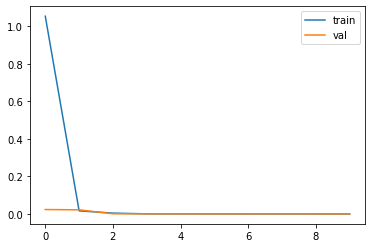

---Training time: 604.45031977 seconds ---
R2 scores: Train - 0.98633, Validation - 0.98346
RMSE scores: Train - 0.01503, Validation - 0.01898


In [6]:
# Build the model

np.random.seed(0)   # To get reproducible results
#tf.random.set_seed(1)

model = Sequential()
model.add(LSTM(32, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16, activation='tanh'))
model.add(Dense(1, kernel_initializer='normal', activation='linear'))
model.compile(loss='mse', optimizer='adam')

start_time = time.time()
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_val, Y_val), verbose=1)
end_time = time.time()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

print("---Training time: %0.8f seconds ---" % (end_time - start_time))

y_predTrain = model.predict(X_train)
train_r2 = r2_score(Y_train, y_predTrain)
train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain))

y_predVal = model.predict(X_val)
val_r2 = r2_score(Y_val, y_predVal)
val_rmse = np.sqrt(mean_squared_error(Y_val, y_predVal))  

print("R2 scores: Train - %0.5f, Validation - %0.5f" %(train_r2, val_r2))
print("RMSE scores: Train - %0.5f, Validation - %0.5f" %(train_rmse, val_rmse))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 300, 32)           4864      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 8,017
Trainable params: 8,017
Non-trainable params: 0
_________________________________________________________________
None


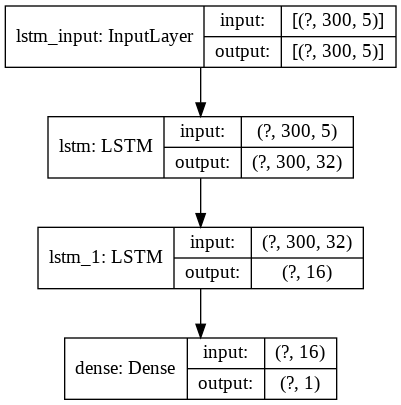

In [7]:
print(model.summary())
plot_model(model, show_shapes=True)
#model.save('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/models/LSTM_ss.h5')

In [8]:
# Evaluate the model


start_time = time.time()
y_predTest = model.predict(x_test)
end_time = time.time()
test_r2 = r2_score(y_test, y_predTest)
test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))

print("Test - \nR2 scores: %0.5f \nRMSE scores: %0.5f" %(test_r2, test_rmse))
print("\n---Time for Test data prediction: %0.8f seconds ---" % (end_time - start_time))


Test - 
R2 scores: 0.94262 
RMSE scores: 0.03461

---Time for Test data prediction: 7.30510283 seconds ---


Text(0.5, 1.0, 'Shear Stress prediction using LSTM model')

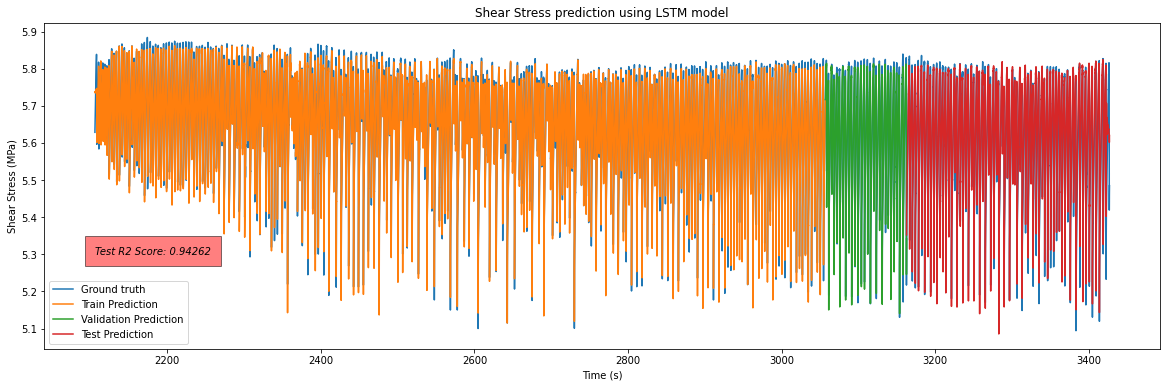

In [9]:
# Overall plot

ttime = df1['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.1, shuffle=False)

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf)
plt.plot(traintime, y_predTrain)
plt.plot(valtime, y_predVal)
plt.plot(testtime, y_predTest)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.text(ttime.iloc[0], 5.3, 'Test R2 Score: %0.5f' %(test_r2), style='italic', bbox=dict(facecolor='red', alpha=0.5, pad=10))
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])
plt.title('Shear Stress prediction using LSTM model')


In [10]:
# Save
'''
hf = h5py.File('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/predictions/res300/lstm_ss.h5', 'w')
hf.create_dataset('y_predTrain', data=y_predTrain)
hf.create_dataset('y_predVal', data=y_predVal)
hf.create_dataset('y_predTest', data=y_predTest)
hf.close()
'''


"\nhf = h5py.File('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/predictions/res300/lstm_ss.h5', 'w')\nhf.create_dataset('y_predTrain', data=y_predTrain)\nhf.create_dataset('y_predVal', data=y_predVal)\nhf.create_dataset('y_predTest', data=y_predTest)\nhf.close()\n"

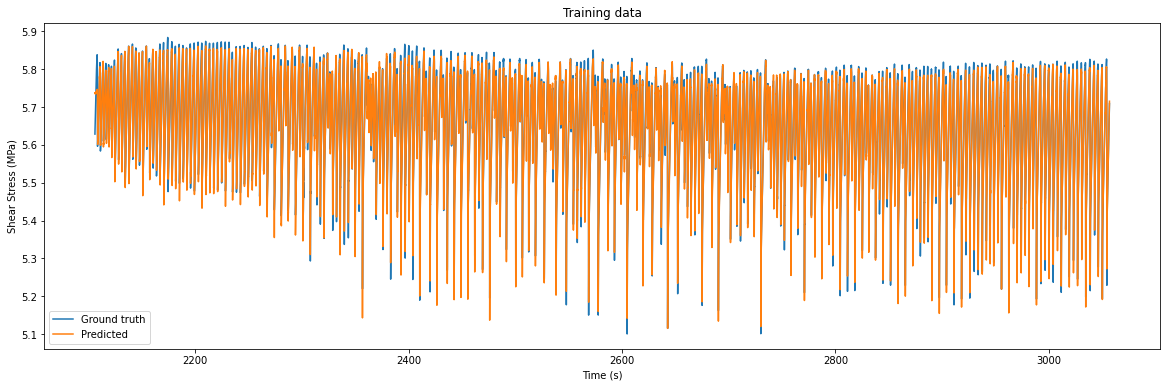

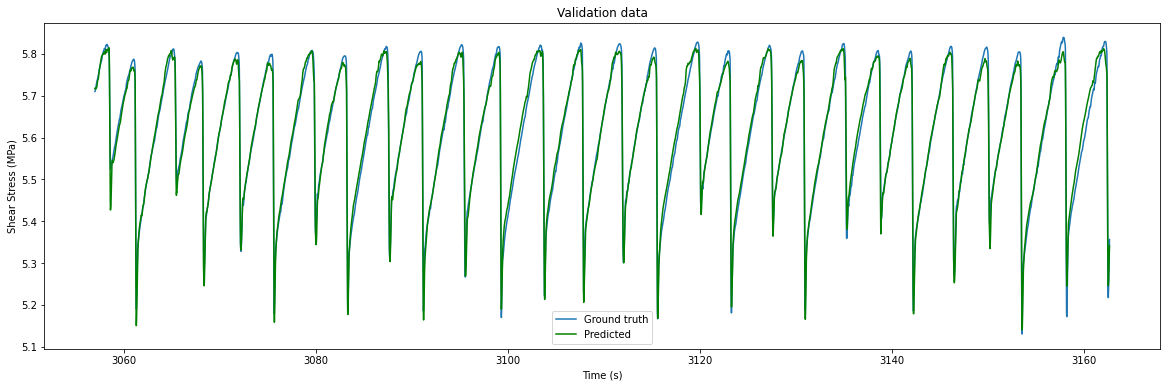

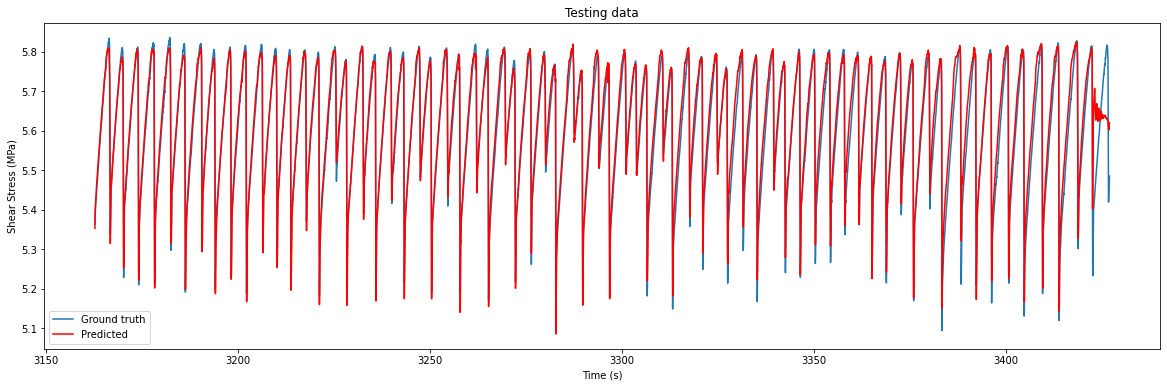

In [11]:
# Individual plots

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train, y_predTrain, 'Training data', '')
results_plot(2, valtime, Y_val, y_predVal, 'Validation data', 'g')
results_plot(3, testtime, y_test, y_predTest, 'Testing data', 'r')


Text(0.5, 1.0, 'Detailed View, Testing Data')

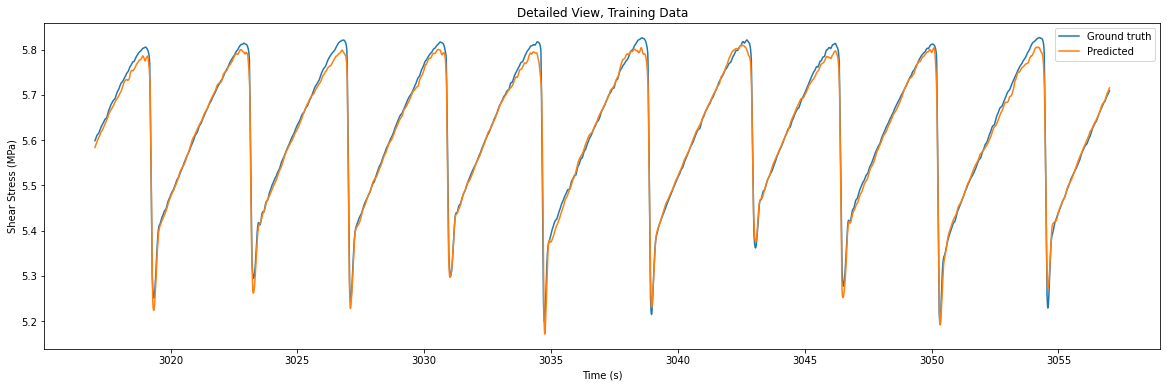

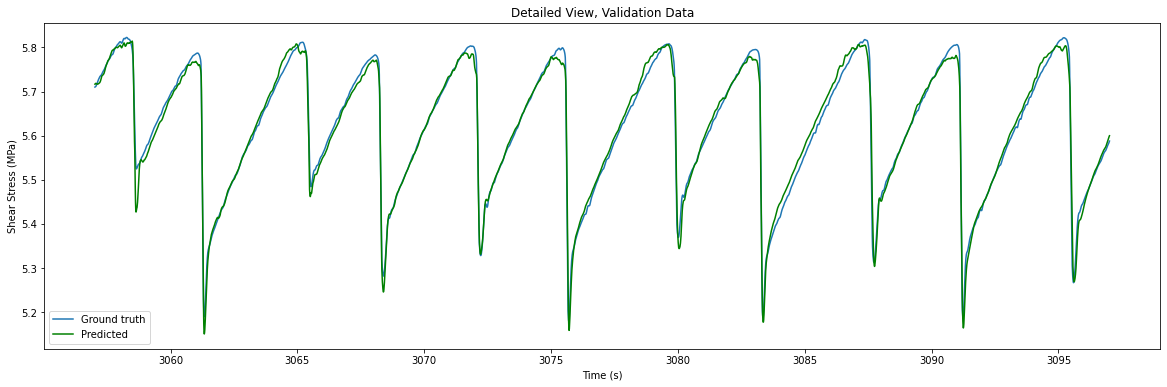

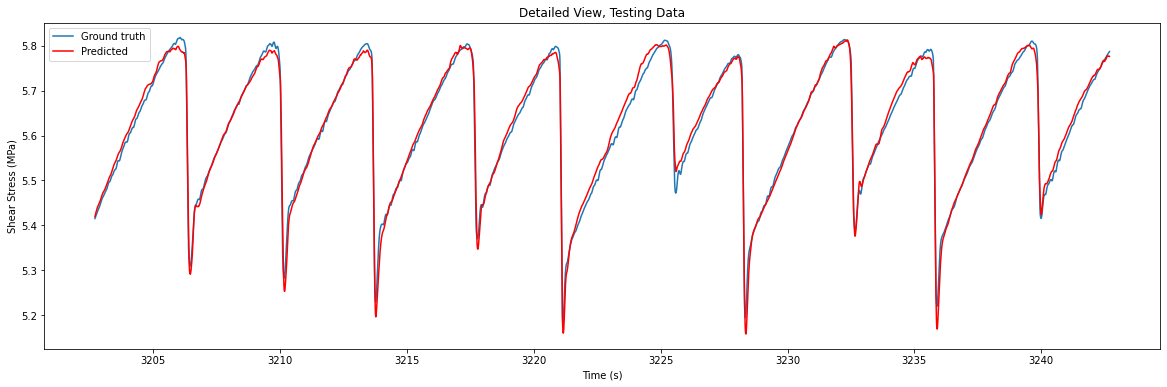

In [12]:
# Detailed view of the plots

n=4000

fig = plt.figure(4, figsize=(20,6))
plt.plot(traintime[-n:], Y_train[-n:])
plt.plot(traintime[-n:], y_predTrain[-n:])
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Training Data')

fig = plt.figure(5, figsize=(20,6))
plt.plot(valtime[:n], Y_val[:n])
plt.plot(valtime[:n], y_predVal[:n], 'g')
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Validation Data')

st_i = 4000
fig = plt.figure(6, figsize=(20,6))
plt.plot(testtime[st_i:st_i+n], y_test[st_i:st_i+n])
plt.plot(testtime[st_i:st_i+n], y_predTest[st_i:st_i+n], 'r')
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Testing Data')
